Topic Modeling - LDA (Machine Learning Plus)

In [1]:
!pip install spacy
!pip install pyLDAvis
!pip install regex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 101.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 25.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvico

In [ ]:
import nltk; nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet
import os
#os.environ.update({'MALLET_HOME':r'Users/mrinal/Downloads/mallet-2.0.8/'})

import spacy

# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Preparing stopwords:

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
!pwd

/content


Importing Data:

In [ ]:

!pip install -U -q PyDrive
import os
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
if not os.path.exists('/content/mtsamples.csv'):
    link = '1WF-mzhdvxni3OX83qOF6S2zWpuPAegMA'  # Restricted shared link
    downloaded = drive.CreateFile({'id':link})
    downloaded.GetContentFile('mtsamples.csv')

__mtData = pd.read_csv('/content/mtsamples.csv', error_bad_lines = False)
__mtText = __mtData[['transcription']]
__naText = __mtText.dropna()
print(__mtData)

      Unnamed: 0                                        description  \
0              0   A 23-year-old white female presents with comp...   
1              1           Consult for laparoscopic gastric bypass.   
2              2           Consult for laparoscopic gastric bypass.   
3              3                             2-D M-Mode. Doppler.     
4              4                                 2-D Echocardiogram   
...          ...                                                ...   
4994        4994   Patient having severe sinusitis about two to ...   
4995        4995   This is a 14-month-old baby boy Caucasian who...   
4996        4996   A female for a complete physical and follow u...   
4997        4997   Mother states he has been wheezing and coughing.   
4998        4998   Acute allergic reaction, etiology uncertain, ...   

                medical_specialty                                sample_name  \
0            Allergy / Immunology                         Allergic 

In [ ]:
# Converting String to List:
__mtList = __mtText.values.tolist()

In [ ]:
# Tokenize words and clean up text:
def sentenceToWords(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

__mtWords = list(sentenceToWords(__mtList))

In [ ]:
# Printing the words obtained:
for i in range(0, len(__mtWords)//1000):
    print(__mtWords[i], '\n')

['subjective', 'this', 'year', 'old', 'white', 'female', 'presents', 'with', 'complaint', 'of', 'allergies', 'she', 'used', 'to', 'have', 'allergies', 'when', 'she', 'lived', 'in', 'seattle', 'but', 'she', 'thinks', 'they', 'are', 'worse', 'here', 'in', 'the', 'past', 'she', 'has', 'tried', 'claritin', 'and', 'zyrtec', 'both', 'worked', 'for', 'short', 'time', 'but', 'then', 'seemed', 'to', 'lose', 'effectiveness', 'she', 'has', 'used', 'allegra', 'also', 'she', 'used', 'that', 'last', 'summer', 'and', 'she', 'began', 'using', 'it', 'again', 'two', 'weeks', 'ago', 'it', 'does', 'not', 'appear', 'to', 'be', 'working', 'very', 'well', 'she', 'has', 'used', 'over', 'the', 'counter', 'sprays', 'but', 'no', 'prescription', 'nasal', 'sprays', 'she', 'does', 'have', 'asthma', 'but', 'doest', 'not', 'require', 'daily', 'medication', 'for', 'this', 'and', 'does', 'not', 'think', 'it', 'is', 'flaring', 'up', 'medications', 'her', 'only', 'medication', 'currently', 'is', 'ortho', 'tri', 'cyclen',

In [ ]:
# Eliminate stopwords, make bigrams and lemmatize:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
import spacy
!python -m spacy download en

# Remove Stop Words
__noStopWords = remove_stopwords(__mtWords)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
__lemmData = lemmatization(__noStopWords, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(__lemmData[:1])

2022-10-18 04:09:36.162830: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 10.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
[['subjective', 'year', 'old', 'white', 'female', 'present', 'complaint', 'allergy', 'use', 'allergy', 'live', 'seattle', 'think', 'bad', 'past', 'try', 'claritin', 'zyrtec', 'work', 'short', 'time', 'seem', 'lose', 'effectiveness', 'use', 'allegra', 'also', 'use', 'last', 'summer', 'begin', 'use', 'week', 'ago', 'appear', 'work', 'well', 'use', 'counter', 'spray', 'nasal', 'spray', 'doest', 'require', 'daily', 'medication', 'think', 'flare', 'medicat

In [ ]:
# Create Dictionary
__id2word = corpora.Dictionary(__lemmData)

# Create Corpus
__textCorpus = __lemmData

# Term Document Frequency
__corpus = [__id2word.doc2bow(text) for text in __textCorpus]

print(__corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 4), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 3), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 3), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 3), (59, 1), (60, 1), (61, 1), (62, 3), (63, 1), (64, 1), (65, 1), (66, 2), (67, 6), (68, 1), (69, 2), (70, 1), (71, 2), (72, 1), (73, 2), (74, 1), (75, 1), (76, 2)]]


In [ ]:
# Human readable format of corpus (term-frequency)
[[(__id2word[id], freq) for id, freq in cp] for cp in __corpus[:1]]

[[('adenopathy', 1),
  ('ago', 1),
  ('allegra', 2),
  ('allergic', 1),
  ('allergy', 4),
  ('also', 1),
  ('appear', 1),
  ('assessment', 1),
  ('bad', 1),
  ('begin', 1),
  ('blood', 1),
  ('cheap', 1),
  ('claritin', 1),
  ('clear', 3),
  ('complaint', 1),
  ('counter', 1),
  ('coverage', 1),
  ('currently', 1),
  ('daily', 1),
  ('doest', 1),
  ('drainage', 1),
  ('effectiveness', 1),
  ('erythematous', 2),
  ('exudate', 1),
  ('female', 1),
  ('flare', 1),
  ('give', 1),
  ('heent', 1),
  ('instead', 1),
  ('know', 1),
  ('last', 1),
  ('live', 1),
  ('loratadine', 1),
  ('lose', 1),
  ('lung', 1),
  ('medication', 3),
  ('medicine', 1),
  ('mildly', 1),
  ('nasal', 2),
  ('nasonex', 1),
  ('neck', 1),
  ('objective', 1),
  ('old', 1),
  ('option', 1),
  ('ortho', 1),
  ('past', 1),
  ('plan', 1),
  ('pound', 1),
  ('prescription', 2),
  ('present', 1),
  ('pressure', 1),
  ('require', 1),
  ('rhinitis', 1),
  ('sample', 1),
  ('seattle', 1),
  ('see', 1),
  ('seem', 1),
  ('short

In [ ]:
# Build LDA model
__ldaModel = gensim.models.ldamodel.LdaModel(corpus = __corpus,
                                           id2word = __id2word,
                                           num_topics = 10,
                                           random_state = 100,
                                           update_every = 1,
                                           chunksize = 100,
                                           passes = 10,
                                           alpha = 'auto',
                                           per_word_topics = True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(__ldaModel.print_topics())
__documentsLDA = __ldaModel[__corpus]

[(0,
  '0.020*"leave" + 0.020*"right" + 0.019*"foot" + 0.018*"nasal" + 0.017*"area" '
  '+ 0.011*"wound" + 0.010*"tissue" + 0.010*"use" + 0.009*"bone" + '
  '0.009*"skin"'),
 (1,
  '0.016*"leave" + 0.015*"right" + 0.014*"knee" + 0.014*"anterior" + '
  '0.013*"fracture" + 0.011*"shoulder" + 0.011*"posterior" + 0.010*"marginal" '
  '+ 0.009*"femoral" + 0.009*"use"'),
 (2,
  '0.025*"place" + 0.019*"use" + 0.019*"suture" + 0.018*"incision" + '
  '0.014*"close" + 0.014*"skin" + 0.013*"leave" + 0.011*"run" + '
  '0.011*"patient" + 0.011*"fashion"'),
 (3,
  '0.029*"normal" + 0.022*"carotid" + 0.018*"note" + 0.014*"abdominal" + '
  '0.012*"cm" + 0.010*"tube" + 0.010*"evidence" + 0.010*"appear" + '
  '0.008*"fluid" + 0.008*"abdoman"'),
 (4,
  '0.049*"patient" + 0.038*"procedure" + 0.016*"place" + 0.014*"use" + '
  '0.014*"remove" + 0.012*"perform" + 0.011*"diagnosis" + 0.008*"complication" '
  '+ 0.008*"well" + 0.008*"room"'),
 (5,
  '0.019*"breast" + 0.018*"cancer" + 0.014*"lesion" + 0.013*"tu

In [ ]:
(__ldaModel.alpha)

array([0.16061532, 0.18702048, 0.12819147, 0.27305278, 0.3842295 ,
       0.26039088, 0.5000093 , 0.9177315 , 0.1483674 , 0.45134458],
      dtype=float32)

A range of alpha values obtained using the 'auto' parameter in LdaModel where the model gives ideal values of alpha to obtain the number of topics listed.

In [ ]:
# # Compute Perplexity
# print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
__coherenceModel = CoherenceModel(model = __ldaModel, texts = __lemmData, dictionary = __id2word, coherence = 'c_v')
__ldaCoherence = __coherenceModel.get_coherence()
print('\nCoherence Score: ', __ldaCoherence)


Coherence Score:  0.46016460911841406


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
__vis = pyLDAvis.gensim_models.prepare(__ldaModel, __corpus, __id2word)
__vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.118115  0.143076       1        1  30.664705
4     -0.164229  0.189158       2        1  14.663176
2     -0.234709  0.111713       3        1  11.838158
6      0.154082 -0.017081       4        1  10.184207
9      0.174262  0.037596       5        1   7.796841
1     -0.132409 -0.021413       6        1   7.444927
3      0.120237 -0.074609       7        1   5.801669
5      0.174939 -0.042543       8        1   4.994121
0     -0.059921  0.011499       9        1   4.349048
8     -0.150367 -0.337396      10        1   2.263148, topic_info=            Term          Freq         Total Category  logprob  loglift
493      patient  21470.000000  21470.000000  Default  30.0000  30.0000
501    procedure   7956.000000   7956.000000  Default  29.0000  29.0000
83        artery   4424.000000   4424.000000  Default  28.0000  28.0000
339        leave  10821.000000  10821.000000  Default  27.0000  27.0000
138      history  10700.000000  10700.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
3615  aspiration    139.110912    412.525290  Topic10  -5.2546   2.7014
181        right    247.158532  10559.062657  Topic10  -4.6798   0.0337
494        place    184.153311   7446.125971  Topic10  -4.9741   0.0887
1256   posterior    154.955829   2396.015060  Topic10  -5.1467   1.0500
651     superior    139.095286   1106.926051  Topic10  -5.2547   1.7142

[648 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
401       1  0.135207    abdoman
401       3  0.111753    abdoman
401       7  0.751916    abdoman
890       1  0.318966  abdominal
890       7  0.680322  abdominal
...     ...       ...        ...
75        7  0.001887       year
75        8  0.075077       year
75        9  0.015938       year
2678      6  0.037981      young
2678      8  0.959022      young

[1263 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 3, 7, 10, 2, 4, 6, 1, 9])

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, mallet_path = None, start = 2, step = 3):
    """
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus = __corpus, num_topics = num_topics, id2word = dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = __textCorpus, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
!pip install -U -q PyDrive
import os
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
if not os.path.exists('/content/mallet-2.0.6.tar.gz'):
    link = '1n88XKuQYt1hEV0Y4ErB8DAZhZxAJwXRP'  # Restricted shared link
    downloaded = drive.CreateFile({'id':link})
    downloaded.GetContentFile('mallet-2.0.6.tar.gz')

!tar -xvzf /content/mallet-2.0.6.tar.gz #download and unzip it first
os.environ.update({'MALLET_HOME':r'/content/mallet-2.0.6/bin/mallet'})

mallet-2.0.6/
mallet-2.0.6/class/
mallet-2.0.6/class/cc/
mallet-2.0.6/class/cc/mallet/
mallet-2.0.6/class/cc/mallet/fst/
mallet-2.0.6/class/cc/mallet/fst/MultiSegmentationEvaluator.class
mallet-2.0.6/class/cc/mallet/fst/CRFWriter.class
mallet-2.0.6/class/cc/mallet/fst/ThreadedOptimizable$ValueHandler.class
mallet-2.0.6/class/cc/mallet/fst/Transducer.class
mallet-2.0.6/class/cc/mallet/fst/SumLatticeScaling$LatticeNode.class
mallet-2.0.6/class/cc/mallet/fst/CRFTrainerByThreadedLabelLikelihood.class
mallet-2.0.6/class/cc/mallet/fst/TokenAccuracyEvaluator.class
mallet-2.0.6/class/cc/mallet/fst/CRFTrainerByValueGradients$OptimizableCRF.class
mallet-2.0.6/class/cc/mallet/fst/MaxLatticeDefault$WeightCache.class
mallet-2.0.6/class/cc/mallet/fst/SimpleTagger.class
mallet-2.0.6/class/cc/mallet/fst/CRF$2.class
mallet-2.0.6/class/cc/mallet/fst/CRF$1.class
mallet-2.0.6/class/cc/mallet/fst/MaxLatticeFactory.class
mallet-2.0.6/class/cc/mallet/fst/Transducer$State.class
mallet-2.0.6/class/cc/mallet/fs

In [ ]:
import os


__malletPath = os.getcwd() + '/mallet-2.0.6/bin/mallet' # update this path
#print(__malletPath)
__ldamallet = gensim.models.wrappers.LdaMallet(__malletPath, corpus = __corpus, num_topics = 10, id2word = __id2word)

In [ ]:
# Topics with their corresponding probabilities
pprint(__ldamallet.show_topics(formatted = False))

# Computing Coherence Score
__coherenceMallet = CoherenceModel(model = __ldamallet, texts = __lemmData, dictionary = __id2word, coherence = 'c_v')
__coherenceLdaMallet = __coherenceMallet.get_coherence()
print('\nCoherence Score: ', __coherenceLdaMallet)

[(0,
  [('leave', 0.045399495924846975),
   ('artery', 0.03597263592026448),
   ('coronary', 0.016333344244050932),
   ('catheter', 0.013572932691783139),
   ('pressure', 0.012460039496797705),
   ('perform', 0.010430646023588971),
   ('stenosis', 0.010277895977218421),
   ('normal', 0.009721449379725704),
   ('procedure', 0.009688717226932016),
   ('pulmonary', 0.009459592157376191)]),
 (1,
  [('patient', 0.0371480339707865),
   ('history', 0.017792585850085443),
   ('blood', 0.016710604278120787),
   ('day', 0.01586906305548161),
   ('discharge', 0.01467544846418727),
   ('show', 0.01236550367959606),
   ('disease', 0.011781577116948468),
   ('time', 0.01029599924433033),
   ('continue', 0.008690201197049453),
   ('admit', 0.0083724764497265)]),
 (2,
  [('place', 0.02529141530563866),
   ('incision', 0.013593931368221427),
   ('procedure', 0.012621184625696863),
   ('suture', 0.012449523435839587),
   ('patient', 0.012335082642601403),
   ('close', 0.011166151683097095),
   ('remove'

In [ ]:
# Coherence Score (using LdaMallet) for a range of values - takes forever to run.
model_list, coherence_values = compute_coherence_values(dictionary = __id2word, corpus = __corpus, mallet_path = __malletPath, texts = __lemmData, start = 2, limit = 50, step = 10)

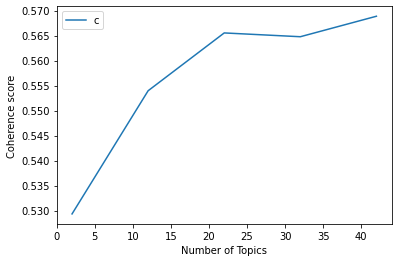

In [ ]:
# Plotting graph for range of Cohernece Values"
limit = 50; start = 2; step = 10;

x = range(start, limit, step)

plt.plot(x, coherence_values)

plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')

plt.show()